In [1]:
import torch
from astra.torch.models import ResNetClassifier,ResNet18_Weights
from astra.torch.data import load_cifar_10
import torch
import torch.nn as nn
from glob import glob
from os.path import expanduser, join, basename, dirname
import xarray as xr
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from torch.utils.data import TensorDataset, DataLoader
from astra.torch.models import ResNetClassifier,ResNet18_Weights
from astra.torch.utils import train_fn

import torchvision.models as models
from astra.torch.metrics import accuracy_score, f1_score, precision_score, recall_score,classification_report

/home/rishabh.mondal/ASTRA/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/rishabh.mondal/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [2]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
range of image values: min=0.0, max=1.0
            

In [3]:
n_train=10000
n_pool=40000
n_test=20000
y=dataset.targets
x=dataset.data
classes=dataset.classes
class_1_idx=classes.index('frog')
class_1_mask=y==class_1_idx
y=class_1_mask.byte()
print(y)
print(len(y))
idx=torch.randperm(len(y))
train_data=x[idx[:n_train]]
train_targets=y[idx[:n_train]]
pool_data=x[idx[n_train:-n_test]]
pool_targets=y[idx[n_train:-n_test]]
test_data=x[idx[-n_test:]]
test_targets=y[idx[-n_test:]]
pool_data=x[idx[:n_pool]]
pool_targets=y[idx[:n_pool]]
print(train_data.shape)
print(train_targets.shape)
print(pool_data.shape)
print(pool_targets.shape)
print(test_data.shape)
print(test_targets.shape)


tensor([1, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)
60000
torch.Size([10000, 3, 32, 32])
torch.Size([10000])
torch.Size([40000, 3, 32, 32])
torch.Size([40000])
torch.Size([20000, 3, 32, 32])
torch.Size([20000])


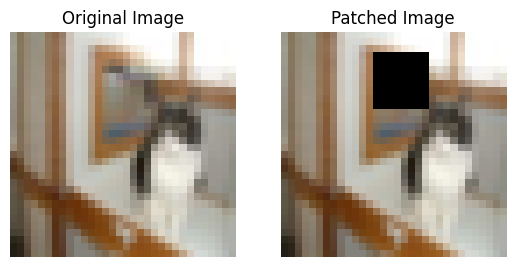

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_data is your dataset containing images
# Replace this with your actual data loading code

# Take one image from the training data
image = train_data[0]

# Define the size of the patch
patch_size = (8, 8)

# Check if the image shape is smaller than the patch size
if image.shape[1] <= patch_size[0] or image.shape[2] <= patch_size[1]:
    print("Image is smaller than the specified patch size.")
    # Handle this case as needed (e.g., skip or use a smaller patch size)
else:
    # Generate random coordinates for the patch
    row_start = np.random.randint(0, image.shape[1] - patch_size[0] + 1)
    row_end = row_start + patch_size[0]
    col_start = np.random.randint(0, image.shape[2] - patch_size[1] + 1)
    col_end = col_start + patch_size[1]

    # Create a copy of the image
    patched_image = np.copy(image)

    # Remove the patch from the image
    patched_image[:, row_start:row_end, col_start:col_end] = 0  # Set to 0 for a black patch in each channel

    # Plot the original and patched images side by side
    plt.subplot(1, 2, 1)
    plt.imshow(np.moveaxis(image.numpy(), 0, -1))  # Convert to NumPy array for visualization
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(np.moveaxis(patched_image, 0, -1))  # Convert to NumPy array for visualization
    plt.title('Patched Image')
    plt.axis('off')

    plt.show()


In [5]:
def remove_patches(images):
    patched_images = images.clone()
    for i in range(images.size(0)):
        # Randomly choose the top-left corner of the patch
        row_start = torch.randint(0, 25, (1,))
        col_start = torch.randint(0, 25, (1,))
        
        # Remove the 8x8 patch
        patched_images[i, :, row_start:row_start+8, col_start:col_start+8] = 0

    return patched_images

In [6]:
train_indices = idx[:n_train]

train_data_patch = remove_patches(dataset.data[train_indices])
print("Train data size:", train_data.size())


Train data size: torch.Size([10000, 3, 32, 32])


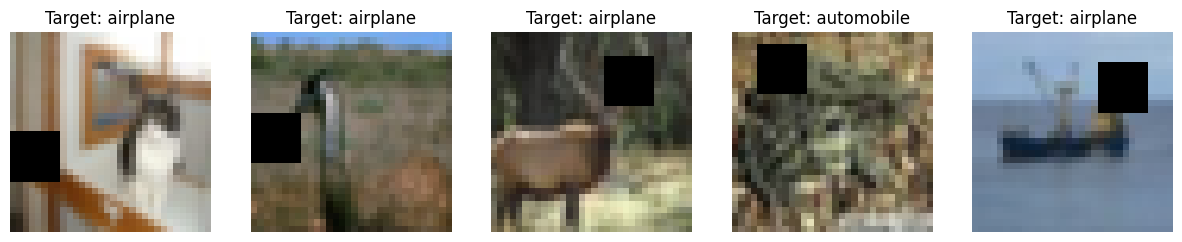

In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Function to display images
def display_images(images, targets, classes, num_images=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = F.to_pil_image(images[i])
        plt.imshow(image)
        plt.title(f"Target: {classes[targets[i].item()]}")
        plt.axis('off')
    plt.show()

# Display five images from the modified train dataset
display_images(train_data_patch, train_targets, dataset.classes, num_images=5)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms.functional as F

# Assuming 'train_data_patch' and 'train_data' are your datasets
# Replace this with your actual data loading code

# Create a custom dataset

# Convert the datasets to DataLoader
train_dataset = TensorDataset(train_data_patch, train_data)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define an autoencoder with a latent space
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        self.latent_dim = latent_dim
    def forward(self, x):
        x = self.encoder(x)
        self.latent_dim=x.clone().detach()
        x = self.decoder(x)
        return x
# Convert the train_data to DataLoader
train_dataset = TensorDataset(train_data_patch, train_data)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# Initialize the autoencoder and define loss and optimizer
autoencoder = Autoencoder(latent_dim=128).to('cuda')
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    for batch in train_loader:
        inputs_patch, inputs_original = batch
        inputs_patch, inputs_original = inputs_patch.to('cuda'), inputs_original.to('cuda')
        
        # Forward pass
        outputs = autoencoder(inputs_patch)
        loss = criterion(outputs, inputs_original)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')




Epoch [1/100], Loss: 0.0626
Epoch [2/100], Loss: 0.0435
Epoch [3/100], Loss: 0.0365
Epoch [4/100], Loss: 0.0323
Epoch [5/100], Loss: 0.0290
Epoch [6/100], Loss: 0.0277
Epoch [7/100], Loss: 0.0255
Epoch [8/100], Loss: 0.0244
Epoch [9/100], Loss: 0.0250
Epoch [10/100], Loss: 0.0230
Epoch [11/100], Loss: 0.0209
Epoch [12/100], Loss: 0.0203
Epoch [13/100], Loss: 0.0190
Epoch [14/100], Loss: 0.0183
Epoch [15/100], Loss: 0.0175
Epoch [16/100], Loss: 0.0167
Epoch [17/100], Loss: 0.0166
Epoch [18/100], Loss: 0.0162
Epoch [19/100], Loss: 0.0157
Epoch [20/100], Loss: 0.0157
Epoch [21/100], Loss: 0.0153
Epoch [22/100], Loss: 0.0144
Epoch [23/100], Loss: 0.0147
Epoch [24/100], Loss: 0.0143
Epoch [25/100], Loss: 0.0139
Epoch [26/100], Loss: 0.0146
Epoch [27/100], Loss: 0.0135
Epoch [28/100], Loss: 0.0137
Epoch [29/100], Loss: 0.0132
Epoch [30/100], Loss: 0.0125
Epoch [31/100], Loss: 0.0129
Epoch [32/100], Loss: 0.0124
Epoch [33/100], Loss: 0.0126
Epoch [34/100], Loss: 0.0122
Epoch [35/100], Loss: 0

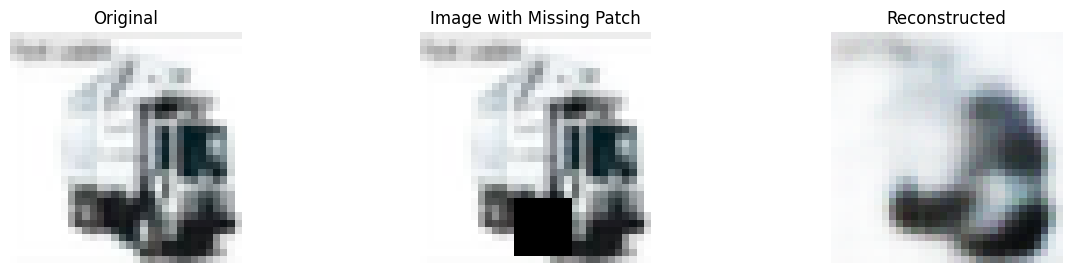

In [9]:
# Evaluate the autoencoder on a sample image
sample_patch, sample_original = train_dataset[5]
sample_patch, sample_original = sample_patch.unsqueeze(0).to('cuda'), sample_original.unsqueeze(0).to('cuda')
reconstructed_images = autoencoder(sample_patch)

# Display the original, patch, and reconstructed images
def display_images(original, patch, reconstructed):
    plt.figure(figsize=(15, 3))
    
    plt.subplot(1, 3, 1)
    plt.imshow(F.to_pil_image(original.squeeze(0).cpu()))
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(F.to_pil_image(patch.squeeze(0).cpu()))
    plt.title("Image with Missing Patch")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(F.to_pil_image(reconstructed.squeeze(0).detach().cpu()))
    plt.title("Reconstructed")
    plt.axis('off')
    
    plt.show()

display_images(sample_original, sample_patch, reconstructed_images)

In [10]:
finetune_dataset = TensorDataset(train_data, train_targets)
finetune_loader = DataLoader(finetune_dataset, batch_size=1024, shuffle=True)


In [11]:
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [13]:
classifier = Classifier(input_dim=128,num_classes=2).to('cuda')
criterion = nn.CrossEntropyLoss()
classifier_optimizer = optim.Adam(classifier.parameters(), lr=0.001)
num_epochs_classifier = 100
for epoch in range(num_epochs_classifier):
    for batch in finetune_loader:
        inputs,targets=batch
        inputs,targets=inputs.to('cuda'),targets.to('cuda')
        # Forward pass
        # Get the encoder output from your pre-trained autoencoder
        latent_dim = autoencoder.encoder(inputs)
        # train the classifier using the encoder output
        classifier_optimizer.zero_grad()
        outputs = classifier(latent_dim)
        classifier_loss = criterion(outputs, targets)

        # Backward pass and optimization
        classifier_loss.backward()
        classifier_optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs_classifier}], Classifier Loss: {classifier_loss.item():.4f}')
    



Epoch [1/100], Classifier Loss: 0.3231
Epoch [2/100], Classifier Loss: 0.3001
Epoch [3/100], Classifier Loss: 0.2559
Epoch [4/100], Classifier Loss: 0.2250
Epoch [5/100], Classifier Loss: 0.2227
Epoch [6/100], Classifier Loss: 0.2669
Epoch [7/100], Classifier Loss: 0.2151
Epoch [8/100], Classifier Loss: 0.2127
Epoch [9/100], Classifier Loss: 0.1840
Epoch [10/100], Classifier Loss: 0.2131
Epoch [11/100], Classifier Loss: 0.2116
Epoch [12/100], Classifier Loss: 0.1938
Epoch [13/100], Classifier Loss: 0.2252
Epoch [14/100], Classifier Loss: 0.1998
Epoch [15/100], Classifier Loss: 0.1866
Epoch [16/100], Classifier Loss: 0.1735
Epoch [17/100], Classifier Loss: 0.1586
Epoch [18/100], Classifier Loss: 0.1901
Epoch [19/100], Classifier Loss: 0.1444
Epoch [20/100], Classifier Loss: 0.1766
Epoch [21/100], Classifier Loss: 0.1899
Epoch [22/100], Classifier Loss: 0.1747
Epoch [23/100], Classifier Loss: 0.1442
Epoch [24/100], Classifier Loss: 0.1650
Epoch [25/100], Classifier Loss: 0.1495
Epoch [26

In [14]:
test_dataset = TensorDataset(test_data, test_targets)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)


[1 0 0 ... 0 0 0]


In [31]:
# # Create an instance of the Autoencoder
# autoencoder = Autoencoder(latent_dim=256)

# # Forward pass with an input tensor
# input_tensor = torch.randn((1, 3, 32, 32))  # Example input tensor
# output_tensor = autoencoder(input_tensor)

# # Access the latent dimension output
# latent_output = autoencoder.latent_dim
# print(latent_output.shape)  # Print the shape of the latent dimension output
# print(latent_output)  # Print the latent dimension output

torch.Size([1, 256])
tensor([[ 0.0566,  0.1333, -0.0802,  0.0089, -0.0336,  0.0086,  0.1155, -0.0937,
          0.0265, -0.0609, -0.0408,  0.0104, -0.0786, -0.0389,  0.0498,  0.2178,
         -0.0111,  0.0492,  0.3295, -0.1099, -0.0614, -0.0747, -0.0186, -0.0317,
          0.0204, -0.0495,  0.0023,  0.0102, -0.0814, -0.2261, -0.1291,  0.0923,
          0.0632,  0.1123,  0.0136,  0.0750,  0.0932,  0.1480,  0.0336, -0.0807,
          0.1081, -0.0670,  0.0201,  0.0046, -0.1774, -0.0203, -0.0622, -0.1943,
         -0.1068, -0.0326,  0.0702, -0.1582,  0.0571, -0.1512,  0.0225, -0.1193,
          0.0765, -0.0585, -0.0443, -0.0722, -0.0914, -0.0466, -0.1800, -0.1373,
          0.0229,  0.0411, -0.0052,  0.0414,  0.1711, -0.1831,  0.1374,  0.0289,
          0.0708, -0.2179,  0.1564,  0.0358,  0.1667,  0.1360,  0.0355, -0.0817,
          0.0349,  0.0763, -0.0718, -0.1251, -0.0660, -0.1262, -0.0072, -0.0164,
         -0.0803, -0.0247, -0.0821, -0.0143,  0.1045,  0.0172,  0.1080, -0.0564,
       

In [9]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# import torchvision.transforms.functional as F

# # Assuming 'train_data_patch' and 'train_data' are your datasets
# # Replace this with your actual data loading code

# # Create a custom dataset
# class PatchedDataset(TensorDataset):
#     def __init__(self, data_patch, data_original):
#         super(PatchedDataset, self).__init__(data_patch, data_original)

#     def __getitem__(self, index):
#         patch_image = self.data_patch[index]
#         original_image = self.data_original[index]
#         return patch_image, original_image

# # Convert the datasets to DataLoader
# train_dataset = PatchedDataset(train_data_patch.float(), train_data.float())
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# # Define a more complex variational autoencoder (VAE)
# class ConvVAE(nn.Module):
#     def __init__(self, latent_dim=256):
#         super(ConvVAE, self).__init__()

#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(256 * 4 * 4, 512),
#             nn.ReLU(),
#             nn.Linear(512, 2 * latent_dim)  # Two outputs for mean and log-variance
#         )

#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 512),
#             nn.ReLU(),
#             nn.Linear(512, 256 * 4 * 4),
#             nn.ReLU(),
#             nn.Unflatten(1, (256, 4, 4)),
#             nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
#             nn.Sigmoid()
#         )

#     def encode(self, x):
#         x = self.encoder(x)
#         mu, logvar = x.chunk(2, dim=1)
#         return mu, logvar

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def decode(self, z):
#         return self.decoder(z)

#     def forward(self, x):
#         mu, logvar = self.encode(x)
#         z = self.reparameterize(mu, logvar)
#         recon_x = self.decode(z)
#         return recon_x, mu, logvar

# # Convert the train_data to DataLoader
# train_dataset = TensorDataset(train_data_patch, train_data)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# # Initialize the ConvVAE and define loss and optimizer
# conv_vae = ConvVAE(latent_dim=256).to('cuda')
# criterion = nn.MSELoss()
# optimizer = optim.Adam(conv_vae.parameters(), lr=0.001)

# # Train the ConvVAE
# num_epochs = 10
# for epoch in range(num_epochs):
#     conv_vae.train()
#     for batch in train_loader:
#         inputs_patch, inputs_original = batch
#         inputs_patch, inputs_original = inputs_patch.to('cuda'), inputs_original.to('cuda')
        
#         # Forward pass
#         recon_batch, mu, logvar = conv_vae(inputs_patch)
#         loss = criterion(recon_batch, inputs_original)

#         # Compute the KL divergence term (KL divergence regularization)
#         kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#         # Combine reconstruction loss and KL divergence
#         total_loss = loss + 0.1 * kl_divergence

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}, Reconstruction Loss: {loss.item():.4f}, KL Divergence: {kl_divergence.item():.4f}')

# # Evaluate the ConvVAE on a sample image
# conv_vae.eval()
# sample_patch, sample_original = train_dataset[0]
# sample_patch, sample_original = sample_patch.view(1, 3, 32, 32).to('cuda'), sample_original.view(1, 3, 32, 32).to('cuda')
# reconstructed_images, _, _ = conv_vae(sample_patch)

# # Display the original, patch, and reconstructed images
# def display_images(original, patch, reconstructed):
#     plt.figure(figsize=(15, 3))
    
#     plt.subplot(1, 3, 1)
#     plt.imshow(F.to_pil_image(original.view(3, 32, 32).cpu()))
#     plt.title("Original")
#     plt.axis('off')
    
#     plt.subplot(1, 3, 2)
#     plt.imshow(F.to_pil_image(patch.view(3, 32, 32).cpu()))
#     plt.title("Image with Missing Patch")
#     plt.axis('off')
    
#     plt.subplot(1, 3, 3)
#     plt.imshow(F.to_pil_image(reconstructed.view(3, 32, 32).detach().cpu()))
#     plt.title("Reconstructed")
#     plt.axis('off')
    
#     plt.show()

# display_images(sample_original, sample_patch, reconstructed_images)


In [10]:
print(reconstructed_images)
print(sample_original)
print(sample_patch)

tensor([[[[0.1516, 0.1440, 0.1344,  ..., 0.3844, 0.3736, 0.3732],
          [0.1470, 0.1402, 0.1399,  ..., 0.3687, 0.3551, 0.3604],
          [0.1548, 0.1545, 0.1644,  ..., 0.3406, 0.3336, 0.3498],
          ...,
          [0.5239, 0.5244, 0.5177,  ..., 0.5349, 0.5565, 0.5958],
          [0.5272, 0.5270, 0.5241,  ..., 0.5553, 0.5731, 0.6006],
          [0.5263, 0.5322, 0.5333,  ..., 0.5833, 0.5894, 0.5838]],

         [[0.1944, 0.1882, 0.1830,  ..., 0.4529, 0.4403, 0.4292],
          [0.1969, 0.1814, 0.1986,  ..., 0.4234, 0.4179, 0.4256],
          [0.2124, 0.2052, 0.2205,  ..., 0.3927, 0.3880, 0.3991],
          ...,
          [0.5361, 0.5274, 0.5220,  ..., 0.5246, 0.5733, 0.6146],
          [0.5399, 0.5356, 0.5374,  ..., 0.5563, 0.5823, 0.5944],
          [0.5419, 0.5477, 0.5429,  ..., 0.5822, 0.6029, 0.6101]],

         [[0.1260, 0.1200, 0.1164,  ..., 0.3362, 0.3347, 0.3286],
          [0.1271, 0.1229, 0.1200,  ..., 0.3156, 0.3134, 0.3193],
          [0.1461, 0.1389, 0.1395,  ..., 0